# Multi Layer Neural Network on Small Dataset

In [2]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()

from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import layers, models, metrics

from scipy import stats

pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

load data into a dataframe, remove match Id and human_players, and then describe it.

In [3]:
# load data into a df
dota_df = pd.read_csv("../data/dota2_matches_small.csv")

#column grouping
target_name = "radiant_win"
human_players = "human_players"
hero_names = dota_df.columns[:121]
clusters = list(dota_df.columns[dota_df.columns.str.contains("cluster")])

dota_df.describe()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,Shadow Fiend,Phantom Lancer,Puck,Pudge,Razor,Sand King,Storm Spirit,Sven,Tiny,Vengeful Spirit,Windranger,Zeus,Kunkka,Lina,Lion,Shadow Shaman,Slardar,Tidehunter,Witch Doctor,Lich,Riki,Enigma,Tinker,Sniper,Necrophos,Warlock,Beastmaster,Queen of Pain,Venomancer,Faceless Void,Wraith King,Death Prophet,Phantom Assassin,Pugna,Templar Assassin,Viper,Luna,Dragon Knight,Dazzle,Clockwerk,Leshrac,Nature's Prophet,Lifestealer,Dark Seer,Clinkz,Omniknight,Enchantress,Huskar,Night Stalker,Broodmother,Bounty Hunter,Weaver,Jakiro,Batrider,Chen,Spectre,Ancient Apparition,Doom,Ursa,Spirit Breaker,Gyrocopter,Alchemist,Invoker,Silencer,Outworld Destroyer,Lycan,Brewmaster,Shadow Demon,Lone Druid,Chaos Knight,Meepo,Treant Protector,Ogre Magi,Undying,Rubick,Disruptor,Nyx Assassin,Naga Siren,Keeper of the Light,Io,Visage,Slark,Medusa,Troll Warlord,Centaur Warrunner,Magnus,Timbersaw,Bristleback,Tusk,Skywrath Mage,Abaddon,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden,Monkey King,Dark Willow,Pangolier,Grimstroke,Hoodwink,Void Spirit,Snapfire,Mars,Dawnbreaker,avg_avg_assists_dire,avg_avg_assists_radiant,avg_avg_deaths_dire,avg_avg_deaths_radiant,avg_avg_kills_dire,avg_avg_kills_radiant,avg_competitive_rank_dire,avg_competitive_rank_radiant,avg_mmr_estimate_dire,avg_mmr_estimate_radiant,avg_solo_competitive_rank_dire,avg_solo_competitive_rank_radiant,avg_wl_hero_ratio_dire,avg_wl_hero_ratio_radiant,avg_wl_ratio_dire,avg_wl_ratio_radiant,max_avg_assists_dire,max_avg_assists_radiant,max_avg_deaths_dire,max_avg_deaths_radiant,max_avg_kills_dire,max_avg_kills_radiant,max_competitive_rank_dire,max_competitive_rank_radiant,max_mmr_estimate_dire,max_mmr_estimate_radiant,max_solo_competitive_rank_dire,max_solo_competitive_rank_radiant,max_wl_hero_ratio_dire,max_wl_hero_ratio_radiant,max_wl_ratio_dire,max_wl_ratio_radiant,min_avg_assists_dire,min_avg_assists_radiant,min_avg_deaths_dire,min_avg_deaths_radiant,min_avg_kills_dire,min_avg_kills_radiant,min_competitive_rank_dire,min_competitive_rank_radiant,min_mmr_estimate_dire,min_mmr_estimate_radiant,min_solo_competitive_rank_dire,min_solo_competitive_rank_radiant,min_wl_hero_ratio_dire,min_wl_hero_ratio_radiant,min_wl_ratio_dire,min_wl_ratio_radiant,std_avg_assists_dire,std_avg_assists_radiant,std_avg_deaths_dire,std_avg_deaths_radiant,std_avg_kills_dire,std_avg_kills_radiant,std_competitive_rank_dire,std_competitive_rank_radiant,std_mmr_estimate_dire,std_mmr_estimate_radiant,std_solo_competitive_rank_dire,std_solo_competitive_rank_radiant,std_wl_hero_ratio_dire,std_wl_hero_ratio_radiant,std_wl_ratio_dire,std_wl_ratio_radiant,cluster_mode_league0,cluster_mode_league1,cluster_mode_league2,cluster_mode_league3,cluster_mode_league4,cluster_mode_league5,cluster_mode_league6,cluster_mode_league7,cluster_mode_league8,cluster_mode_league9,cluster_mode_league10,cluster_mode_league11,cluster_mode_league12,cluster_mode_league13,cluster_mode_league14,cluster_mode_league15,cluster_mode_league16,cluster_mode_league17,cluster_mode_league18,cluster_mode_league19,cluster_mode_league20,cluster_mode_league21,cluster_mode_league22,cluster_mode_league23,cluster_mode_league24,cluster_mode_league25,cluster_mode_league26,cluster_mode_league27
count,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.0,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,8.44e+02,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.0,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.0,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,8.44e+02,844.00,844.00,8.44e+02,844.00,844.00,844.00,8.44e+02,844.00,844.0,844.00,844.00,844.00,844.00,844.00,844.00,844.00,844.00,

List each column with details, shows all columns as floating point values

In [4]:
print(dota_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Columns: 214 entries, Anti-Mage to radiant_win
dtypes: bool(1), float64(213)
memory usage: 1.4 MB
None


Fix data issues:

<ul>
    <li>Convert hero variables from float to int of 1 and -1</li>
    <li>Convert cluster variables from float to int of 1 and 0</li>
</ul>

In [5]:
dota_df[hero_names] = dota_df[hero_names].replace(1.0, 'dire').replace(2.0, 'radiant').astype(str)
dota_df[clusters] = dota_df[clusters].astype(int)
dota_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Columns: 214 entries, Anti-Mage to radiant_win
dtypes: bool(1), float64(64), int32(28), object(121)
memory usage: 1.3+ MB


Split into train test and pass through neural network

In [6]:
features = dota_df.drop(target_name, axis=1)
features = pd.get_dummies(features, columns=hero_names)

target = dota_df[target_name].astype(bool)
features.shape

(844, 453)

Plot model loss

In [7]:
def plot_loss(data):
  plt.plot(data.history['loss'], label='loss')
  plt.plot(data.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

Function for training model

In [12]:
def train_model(seq_model, train, y):
    seq_model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.SGD(0.1),
      metrics=[metrics.BinaryAccuracy(), metrics.Recall(), metrics.Precision()]
    )

    history = seq_model.fit(
        train,
        y,
        epochs=30,
        validation_split = 0.1, #Low due to less training samples available
        verbose=0,
        workers=4,
        shuffle=True
    )

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    return history

Create model and fit to it for all features

In [13]:
test_results = {'loss': [], 'accuracy': [], 'recall': [], 'F1': []}
kf = model_selection.KFold(shuffle=True, random_state=7)

for train, test in kf.split(features):
    model = models.Sequential([
        tf.keras.layers.BatchNormalization(), #normalize the input
        layers.Dense(451, activation='relu'),
        layers.Dense(451, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])

    mod_history = train_model(model, features.values[train], target.values[train])
    res = model.evaluate(features.values[test], target.values[test], verbose=0)

    test_results['loss'] += [res[0]]
    test_results['accuracy'] += [res[1]]
    test_results['recall'] += [res[2]]
    test_results['F1'] += [stats.hmean([res[2], res[3]])]

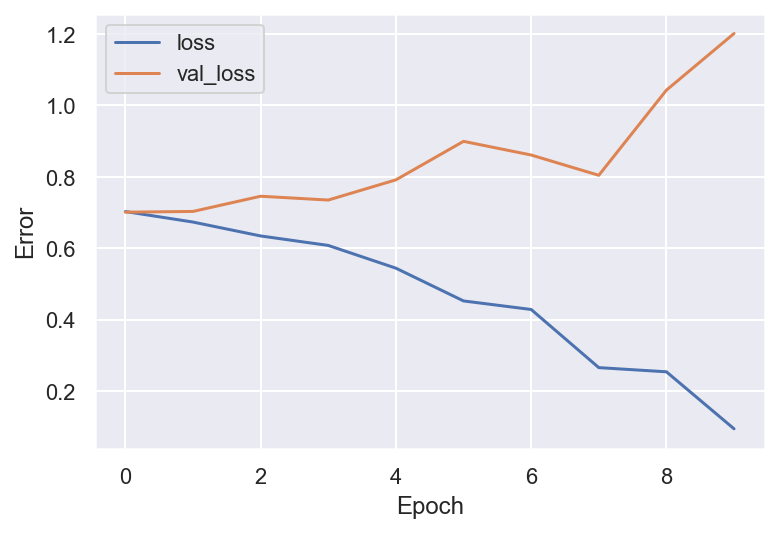

In [14]:
plot_loss(mod_history)

Get test set results

In [15]:
ann_small = {}
for i in test_results.keys():
    ann_small[i] = f'{np.round(np.average(test_results[i]), 3)} +/- {np.round(np.std(test_results[i]), 3)}'

ann_small

{'loss': '1.092 +/- 0.122',
 'accuracy': '0.403 +/- 0.039',
 'recall': '0.301 +/- 0.173',
 'F1': '0.313 +/- 0.118'}